In [11]:
import os
import parse
import fasttext
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
datadir = "/home/peterr/macocu/task5_webgenres/data/final/fasttext2"

dev_full = os.path.join(datadir, "dev_onlyprimary_True_dedup_False.fasttext")
test_full = os.path.join(datadir, "test_onlyprimary_True_dedup_False.fasttext")
train_full = os.path.join(datadir, "train_onlyprimary_True_dedup_False.fasttext")


dev_dd = os.path.join(datadir, "dev_onlyprimary_True_dedup_True.fasttext")
test_dd = os.path.join(datadir, "test_onlyprimary_True_dedup_True.fasttext")
train_dd = os.path.join(datadir, "train_onlyprimary_True_dedup_True.fasttext")


train_ok = os.path.join(datadir, "train_onlyprimary_True_only_keep_True.fasttext")


train_labels = ['__label__Legal/Regulation', '__label__Opinionated_News', '__label__News/Reporting', '__label__Forum', '__label__Correspondence', '__label__Invitation', '__label__Instruction', '__label__Recipe', '__label__Opinion/Argumentation', '__label__Promotion_of_Services', '__label__Promotion', '__label__List_of_Summaries/Excerpts', '__label__Promotion_of_a_Product', '__label__Call', '__label__Review', '__label__Other', '__label__Information/Explanation', '__label__Interview', '__label__Prose', '__label__Research_Article', '__label__Announcement']

STR_TO_NUM = {s: i for i, s in enumerate(train_labels)}
NUM_TO_STR = {i: s for i, s in enumerate(train_labels)}


def parse_fasttext_file(path: str, encode=True):
    """Reads fasttext formatted file and returns dataframe."""
    with open(path, "r") as f:
        content = f.readlines()
    pattern = "{label} {text}\n"
    p = parse.compile(pattern)

    labels, texts = list(), list()
    for line in content:
        rez = p.parse(line)
        if rez is not None:
            labels.append(rez["label"])
            texts.append(rez["text"])
        else:
            pass
            #print("error parsing line ", line)
    if encode:
        labels = [STR_TO_NUM[i] for i in labels]
    return pd.DataFrame(data={"text": texts, "labels": labels})

for filename in [train_full, train_dd, test_full, test_dd, dev_full, dev_dd]:
    try:
        _ = parse_fasttext_file(filename)
    except Exception as e:
        raise e


def train_model(train_df, NUM_EPOCHS=30):
    from simpletransformers.classification import ClassificationModel
    model_args = {
        "num_train_epochs": NUM_EPOCHS,
        "learning_rate": 1e-5,
        "overwrite_output_dir": True,
        "train_batch_size": 32,
        "no_save": True,
        "no_cache": True,
        "overwrite_output_dir": True,
        "save_steps": -1,
        "max_seq_length": 512,
        "silent": True
    }

    model = ClassificationModel(
        "camembert", "EMBEDDIA/sloberta",
        num_labels = 21,
        use_cuda = True,
        args = model_args
    )
    model.train_model(train_df)
    return model

def eval_model(test_df):
    y_true_enc = test_df.labels
    y_pred_enc = model.predict(test_df.text.tolist())[0]

    y_true = [NUM_TO_STR[i] for i in y_true_enc]
    y_pred = [NUM_TO_STR[i] for i in y_pred_enc]

    microF1 = f1_score(y_true, y_pred, labels=train_labels, average ="micro")
    macroF1 = f1_score(y_true, y_pred, labels=train_labels, average ="macro")

    return {"microF1": microF1, 
            "macroF1": macroF1}

import pandas as pd

results = list()

train_full_df = parse_fasttext_file(train_full)
test_full_df = parse_fasttext_file(test_full)
dev_full_df = parse_fasttext_file(dev_full)

dev_dd_df = parse_fasttext_file(dev_dd)
test_dd_df = parse_fasttext_file(test_dd)
train_dd_df = parse_fasttext_file(train_dd)

train_ok_df = parse_fasttext_file(train_ok)


# First experiment: train on full, eval on all available 
for i in range(5):
    print("Run ", i+1, "of 5")
    model = train_model(train_full_df)

    rundict = eval_model(test_full_df)
    rundict["train"] = "full"
    rundict["eval"] = "test_full"
    results.append(rundict)

    rundict = eval_model(dev_full_df)
    rundict["train"] = "full"
    rundict["eval"] = "dev_full"
    results.append(rundict)

    devtest_full_df = pd.concat([test_full_df, dev_full_df], ignore_index=True)

    rundict = eval_model(devtest_full_df)
    rundict["train"] = "full"
    rundict["eval"] = "devtest_full"
    results.append(rundict)


# Second experiment: train on dedup, eval on all available 
for i in range(5):
    print("Run ", i+1, "of 5")
    model = train_model(train_dd_df)

    rundict = eval_model(dev_dd_df)
    rundict["train"] = "dd"
    rundict["eval"] = "dev_dd"
    results.append(rundict)

    rundict = eval_model(test_dd_df)
    rundict["train"] = "dd"
    rundict["eval"] = "test_dd"
    results.append(rundict)

    devtest_dd_df = pd.concat([test_dd_df, dev_dd_df], ignore_index=True)

    rundict = eval_model(devtest_dd_df)
    rundict["train"] = "dd"
    rundict["eval"] = "devtest_dd"
    results.append(rundict)

# Third experiment: train on only keep, eval on all available 
for i in range(5):
    print("Run ", i+1, "of 5")
    model = train_model(train_ok_df)

    rundict = eval_model(dev_dd_df)
    rundict["train"] = "ok"
    rundict["eval"] = "dev_dd"
    results.append(rundict)

    rundict = eval_model(test_dd_df)
    rundict["train"] = "ok"
    rundict["eval"] = "test_dd"
    results.append(rundict)

    devtest_dd_df = pd.concat([test_dd_df, dev_dd_df], ignore_index=True)

    rundict = eval_model(devtest_dd_df)
    rundict["train"] = "ok"
    rundict["eval"] = "devtest_dd"
    results.append(rundict)


    rundict = eval_model(test_full_df)
    rundict["train"] = "ok"
    rundict["eval"] = "test_full"
    results.append(rundict)

    rundict = eval_model(dev_full_df)
    rundict["train"] = "ok"
    rundict["eval"] = "dev_full"
    results.append(rundict)

    devtest_full_df = pd.concat([test_full_df, dev_full_df], ignore_index=True)

    rundict = eval_model(devtest_full_df)
    rundict["train"] = "ok"
    rundict["eval"] = "devtest_full"
    results.append(rundict)

print(results)

Run  1 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

Run  2 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

Run  3 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

Run  4 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

Run  5 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

Run  1 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

Run  2 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

Run  3 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

Run  4 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

Run  5 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

Run  1 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

Run  2 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

Run  3 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

Run  4 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

Run  5 of 5


Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bia

[{'microF1': 0.585, 'macroF1': 0.571702071141847, 'train': 'full', 'eval': 'test_full'}, {'microF1': 0.575, 'macroF1': 0.5038823287921238, 'train': 'full', 'eval': 'dev_full'}, {'microF1': 0.58, 'macroF1': 0.5404399893933838, 'train': 'full', 'eval': 'devtest_full'}, {'microF1': 0.585, 'macroF1': 0.5966322527043888, 'train': 'full', 'eval': 'test_full'}, {'microF1': 0.59, 'macroF1': 0.5424094544007411, 'train': 'full', 'eval': 'dev_full'}, {'microF1': 0.5875, 'macroF1': 0.5722383837732403, 'train': 'full', 'eval': 'devtest_full'}, {'microF1': 0.625, 'macroF1': 0.622224565151736, 'train': 'full', 'eval': 'test_full'}, {'microF1': 0.555, 'macroF1': 0.5010989686144965, 'train': 'full', 'eval': 'dev_full'}, {'microF1': 0.59, 'macroF1': 0.5567143173798803, 'train': 'full', 'eval': 'devtest_full'}, {'microF1': 0.6, 'macroF1': 0.5703267983378637, 'train': 'full', 'eval': 'test_full'}, {'microF1': 0.56, 'macroF1': 0.42015898713758115, 'train': 'full', 'eval': 'dev_full'}, {'microF1': 0.58, 'ma

In [12]:
print(results)

[{'microF1': 0.585, 'macroF1': 0.571702071141847, 'train': 'full', 'eval': 'test_full'}, {'microF1': 0.575, 'macroF1': 0.5038823287921238, 'train': 'full', 'eval': 'dev_full'}, {'microF1': 0.58, 'macroF1': 0.5404399893933838, 'train': 'full', 'eval': 'devtest_full'}, {'microF1': 0.585, 'macroF1': 0.5966322527043888, 'train': 'full', 'eval': 'test_full'}, {'microF1': 0.59, 'macroF1': 0.5424094544007411, 'train': 'full', 'eval': 'dev_full'}, {'microF1': 0.5875, 'macroF1': 0.5722383837732403, 'train': 'full', 'eval': 'devtest_full'}, {'microF1': 0.625, 'macroF1': 0.622224565151736, 'train': 'full', 'eval': 'test_full'}, {'microF1': 0.555, 'macroF1': 0.5010989686144965, 'train': 'full', 'eval': 'dev_full'}, {'microF1': 0.59, 'macroF1': 0.5567143173798803, 'train': 'full', 'eval': 'devtest_full'}, {'microF1': 0.6, 'macroF1': 0.5703267983378637, 'train': 'full', 'eval': 'test_full'}, {'microF1': 0.56, 'macroF1': 0.42015898713758115, 'train': 'full', 'eval': 'dev_full'}, {'microF1': 0.58, 'ma

In [13]:
import json

with open("backup_17.txt", "w") as f:
    json.dump(results, f)

# Analysis

In [1]:
import json
import pandas as pd
pd.set_option("precision", 3)
with open("backup_17.txt") as f:
    content = json.load(f)
jsonlikecontent = dict()
for key in content[0].keys():
    jsonlikecontent[key] = [i[key] for i in content]



df = pd.DataFrame(data=jsonlikecontent)
df.tail()

,microF1,macroF1,train,eval
55,0.594,0.566,ok,test_dd
56,0.598,0.580,ok,devtest_dd
57,0.555,0.584,ok,test_full
58,0.545,0.447,ok,dev_full
59,0.550,0.541,ok,devtest_full


In [2]:
df.groupby(by=["train", "eval"]).agg(["mean", "std"])

microF1        macroF1       
                      mean    std    mean    std
train eval                                      
dd    dev_dd         0.599  0.013   0.543  0.029
      devtest_dd     0.616  0.013   0.595  0.022
      test_dd        0.634  0.018   0.607  0.029
full  dev_full       0.571  0.014   0.489  0.045
      devtest_full   0.585  0.005   0.551  0.030
      test_full      0.600  0.017   0.599  0.028
ok    dev_dd         0.608  0.015   0.544  0.032
      dev_full       0.533  0.014   0.447  0.052
      devtest_dd     0.602  0.004   0.576  0.013
      devtest_full   0.536  0.016   0.513  0.041
      test_dd        0.596  0.018   0.542  0.021
      test_full      0.540  0.026   0.526  0.062

In [16]:
print(_.to_markdown())

|                          |   ('microF1', 'mean') |   ('microF1', 'std') |   ('macroF1', 'mean') |   ('macroF1', 'std') |
|:-------------------------|----------------------:|---------------------:|----------------------:|---------------------:|
| ('dd', 'dev_dd')         |              0.598995 |           0.0130072  |              0.542702 |            0.0290347 |
| ('dd', 'devtest_dd')     |              0.616162 |           0.0133624  |              0.594515 |            0.0224479 |
| ('dd', 'test_dd')        |              0.633503 |           0.0177302  |              0.607424 |            0.0285351 |
| ('full', 'dev_full')     |              0.571    |           0.0138744  |              0.489071 |            0.0449579 |
| ('full', 'devtest_full') |              0.5855   |           0.00512348 |              0.550986 |            0.0297173 |
| ('full', 'test_full')    |              0.6      |           0.0165831  |              0.598651 |            0.0283954 |
| ('ok', 'dev_dd

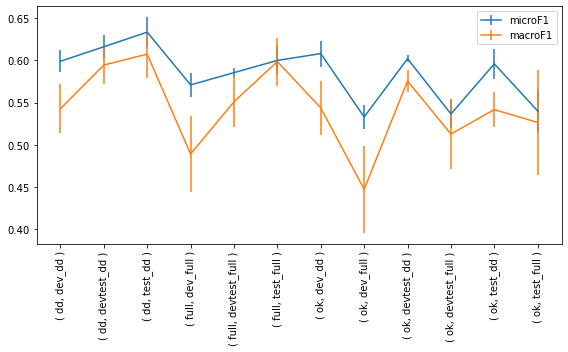

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 5))
df["setup"] = [f"( {train}, {e} )" for train, e in zip(df.train.values, df["eval"].values)]
gbdf = df.groupby(by="setup").mean()
stds = df.groupby(by="setup").std()

ax.errorbar(gbdf.index, gbdf.microF1, yerr=stds.microF1, label="microF1")
ax.errorbar(gbdf.index, gbdf.macroF1, yerr=stds.macroF1, label="macroF1")

ax.tick_params(axis='x', labelrotation= 90)
ax.legend()
fig.tight_layout()
plt.savefig("images/17_stats_plot.png")

In [22]:
c_train_ok = df.train == "ok"
c_eval_dev_dd = df["eval"] == "dev_dd"
c_eval_test_dd = df["eval"] == "test_dd"
c_eval_devtest_dd = df["eval"] == "devtest_dd"

# First question: are the micros F1 different?
from scipy import stats
#Candidate:
higher = df.loc[c_train_ok & c_eval_dev_dd, "macroF1"]
#Alternative
lower = df.loc[c_train_ok & c_eval_devtest_dd, "macroF1"]

# print(f"Wilcoxon p value: {stats.wilcoxon(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

print(f"MannWhithey p value: {stats.mannwhitneyu(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

print(f"Student p value: {stats.ttest_ind(higher,lower)[1]:0.3}", "\t\t(null hypothesis: samples have identical average, equal variance is assumed but not necessary)")
import numpy as np
print(f"Higher average: {np.mean(higher):0.4}, lower average: {np.mean(lower):0.4}")


MannWhithey p value: 0.953 		(alternative hypothesis: first is greater than the second)
Student p value: 0.0715 		(null hypothesis: samples have identical average, equal variance is assumed but not necessary)
Higher average: 0.5437, lower average: 0.5756


In [3]:
print(df.groupby("train").agg(["mean", "std"]).to_markdown())

| train   |   ('microF1', 'mean') |   ('microF1', 'std') |   ('macroF1', 'mean') |   ('macroF1', 'std') |
|:--------|----------------------:|---------------------:|----------------------:|---------------------:|
| dd      |               0.61622 |            0.0200452 |              0.581547 |            0.0381523 |
| full    |               0.5855  |            0.017066  |              0.546236 |            0.0567143 |
| ok      |               0.56925 |            0.0369484 |              0.524577 |            0.0545578 |


In [7]:


from utils import *
import os
import parse
import fasttext
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
datadir = "/home/peterr/macocu/task5_webgenres/data/final/fasttext2"

dev_full = os.path.join(datadir, "dev_onlyprimary_True_dedup_False.fasttext")
test_full = os.path.join(datadir, "test_onlyprimary_True_dedup_False.fasttext")
train_full = os.path.join(datadir, "train_onlyprimary_True_dedup_False.fasttext")


dev_dd = os.path.join(datadir, "dev_onlyprimary_True_dedup_True.fasttext")
test_dd = os.path.join(datadir, "test_onlyprimary_True_dedup_True.fasttext")
train_dd = os.path.join(datadir, "train_onlyprimary_True_dedup_True.fasttext")
dev_dd_df = parse_fasttext_file(dev_dd)
test_dd_df = parse_fasttext_file(test_dd)
train_dd_df = parse_fasttext_file(train_dd)

train_ok = os.path.join(datadir, "train_onlyprimary_True_only_keep_True.fasttext")
results = list()


rundict = eval_model(test_dd_df, model)
rundict["train"] = "dd"
rundict["eval"] = "test_dd"
results.append(rundict)

rundict = eval_model(dev_dd_df, model)
rundict["train"] = "dd"
rundict["eval"] = "dev_dd"
results.append(rundict)

devtest_dd_df = pd.concat([test_dd_df, dev_dd_df], ignore_index=True)

rundict = eval_model(devtest_dd_df, model)
rundict["train"] = "dd"
rundict["eval"] = "devtest_dd"
results.append(rundict)
for i in range(5):
    model = train_model(train_dd_df)
    rundict = eval_model(test_dd_df, model)
    rundict["train"] = "dd"
    rundict["eval"] = "test_dd"
    results.append(rundict)

    rundict = eval_model(dev_dd_df, model)
    rundict["train"] = "dd"
    rundict["eval"] = "dev_dd"
    results.append(rundict)

    devtest_dd_df = pd.concat([test_dd_df, dev_dd_df], ignore_index=True)

    rundict = eval_model(devtest_dd_df, model)
    rundict["train"] = "dd"
    rundict["eval"] = "devtest_dd"
    results.append(rundict)

Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'c

In [9]:
import json

with open("backup_17__2.txt", "w") as f:
    json.dump(results, f)

import json
import pandas as pd
pd.set_option("precision", 3)
with open("backup_17__2.txt") as f:
    content = json.load(f)
jsonlikecontent = dict()
for key in content[0].keys():
    jsonlikecontent[key] = [i[key] for i in content]



df = pd.DataFrame(data=jsonlikecontent)
df.tail()


,microF1,macroF1,y_true,y_pred,train,eval
13,0.578,0.489,"[2, 2, 2, 1, 1, 1, 16, 16, 16, 6, 6, 6, 8, 8, ...","[2, 2, 2, 2, 2, 2, 16, 16, 16, 6, 6, 6, 8, 8, ...",dd,dev_dd
14,0.606,0.566,"[12, 12, 12, 16, 16, 16, 8, 8, 8, 9, 9, 9, 12,...","[12, 12, 12, 16, 16, 16, 1, 1, 1, 9, 9, 9, 12,...",dd,devtest_dd
15,0.599,0.593,"[12, 12, 12, 16, 16, 16, 8, 8, 8, 9, 9, 9, 12,...","[12, 12, 12, 16, 16, 16, 1, 1, 1, 9, 9, 9, 12,...",dd,test_dd
16,0.613,0.603,"[2, 2, 2, 1, 1, 1, 16, 16, 16, 6, 6, 6, 8, 8, ...","[2, 2, 2, 2, 2, 2, 16, 16, 16, 6, 6, 6, 8, 8, ...",dd,dev_dd
17,0.606,0.598,"[12, 12, 12, 16, 16, 16, 8, 8, 8, 9, 9, 9, 12,...","[12, 12, 12, 16, 16, 16, 1, 1, 1, 9, 9, 9, 12,...",dd,devtest_dd


In [ ]:
def read_record(filename: str) -> pd.DataFrame:
    import json
    import pandas as pd
    pd.set_option("precision", 3)
    with open(filename) as f:
        content = json.load(f)
    jsonlikecontent = dict()
    for key in content[0].keys():
        jsonlikecontent[key] = [i[key] for i in content]
    df = pd.DataFrame(data=jsonlikecontent)
    return df